<center>
<img src="img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>
Авторы материала: Ольга Дайховская (@aiho), Юрий Кашницкий (@yorko). 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 2
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь").

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [4]:
# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.concatenate([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [9]:
# Ваш код здесь
n_components_90 = pca.n_components_
print(f"Минимальное число главных компонент для 90% дисперсии: {n_components_90}")
n_components_90

Минимальное число главных компонент для 90% дисперсии: 65


np.int64(65)

**Варианты:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [10]:
# Ваш код здесь
first_component_variance = pca.explained_variance_ratio_[0] * 100
print(f"Процент дисперсии первой главной компоненты: {first_component_variance:.0f}%")
int(first_component_variance)

Процент дисперсии первой главной компоненты: 51%


50

Визуализируйте данные в проекции на первые две главные компоненты.

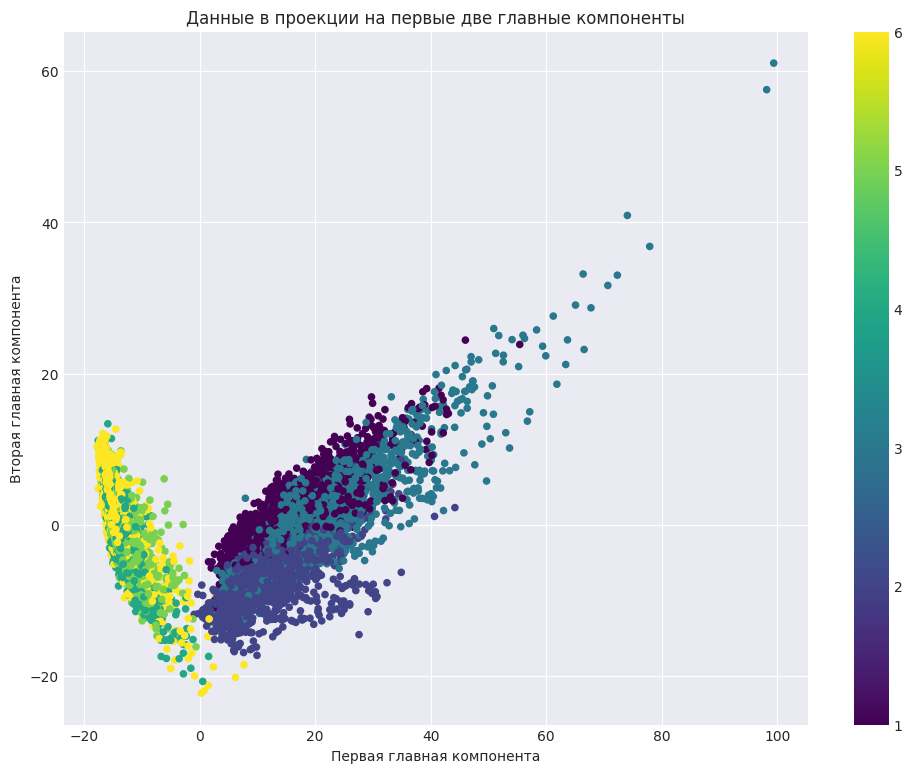

In [11]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Данные в проекции на первые две главные компоненты')
plt.colorbar()
plt.show();

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
# Ваш код здесь
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

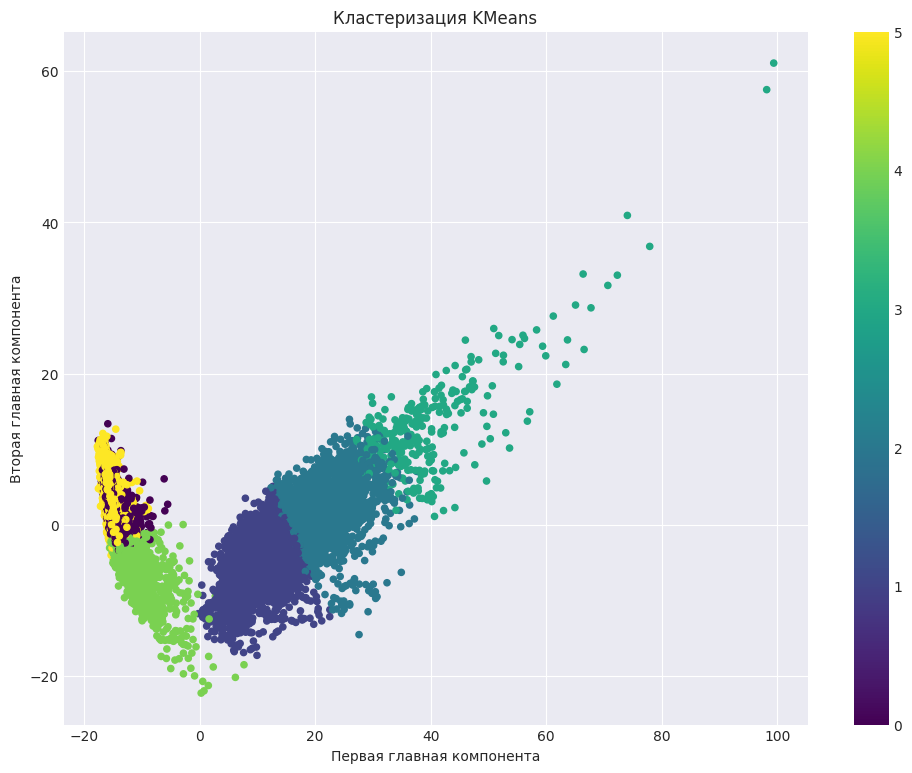

In [13]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Кластеризация KMeans')
plt.colorbar()
plt.show();

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [14]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


In [15]:
# Вычисление метрики для вопроса 4
# Найдем максимальную долю объектов в каждом классе, отнесенных к одному кластеру
max_fractions = []
class_names = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 'сидение', 'стояние', 'лежание']

# Уберем строку и столбец 'все' из таблицы для расчетов
tab_no_margins = tab.iloc[:-1, :-1]

for i, class_name in enumerate(class_names):
    # Находим максимальное количество объектов в кластере для данного класса
    max_count = tab_no_margins.iloc[i].max()
    # Находим общее количество объектов данного класса
    total_count = tab_no_margins.iloc[i].sum()
    # Вычисляем долю
    fraction = max_count / total_count
    max_fractions.append(fraction)
    print(f"{class_name}: максимальная доля = {fraction:.4f} ({max_count}/{total_count})")

# Найдем класс с максимальной долей
best_class_idx = np.argmax(max_fractions)
best_class = class_names[best_class_idx]
best_fraction = max_fractions[best_class_idx]

print(f"\nЛучше всего отделился класс: {best_class} (доля = {best_fraction:.4f})")


ходьба: максимальная доля = 0.5244 (903/1722)
подъем вверх по лестнице: максимальная доля = 0.8038 (1241/1544)
спуск по лестнице: максимальная доля = 0.6330 (890/1406)
сидение: максимальная доля = 0.6950 (1235/1777)
стояние: максимальная доля = 0.7051 (1344/1906)
лежание: максимальная доля = 0.8014 (1558/1944)

Лучше всего отделился класс: подъем вверх по лестнице (доля = 0.8038)


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

/tmp/ipykernel_13196/1230494128.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

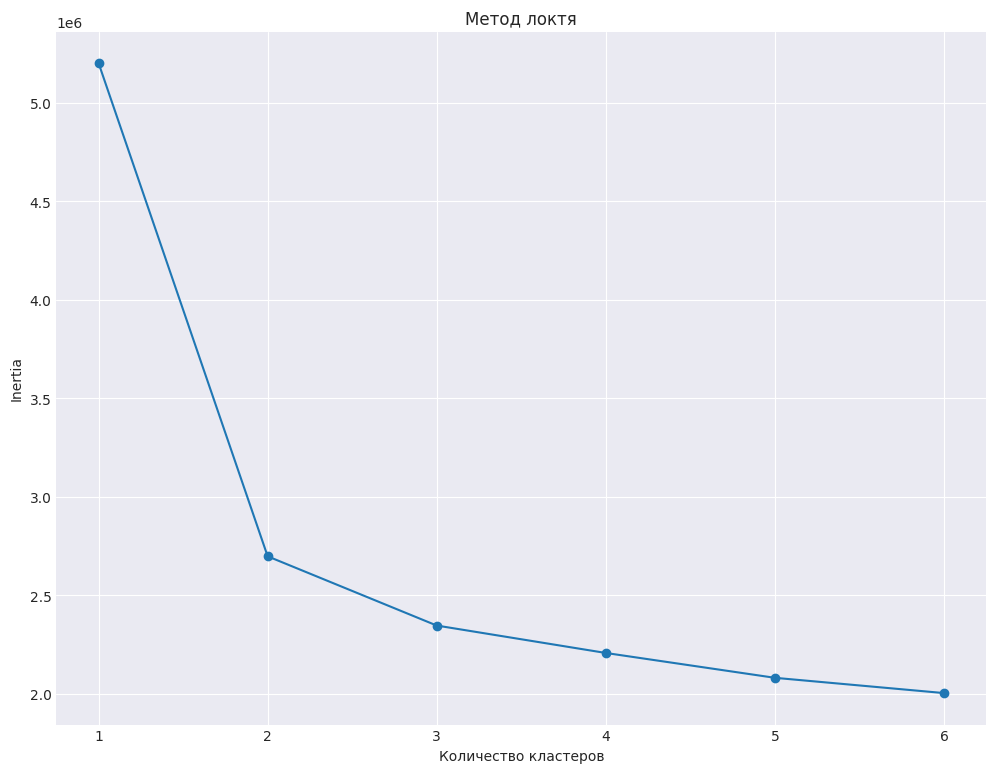

In [16]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans_temp = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(kmeans_temp.inertia_)

plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя')
plt.grid(True)
plt.show();

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [17]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [18]:
# Ваш код здесь
# KMeans с параметрами из задания к 4 вопросу (n_clusters=n_classes, n_init=100)
kmeans_ari = metrics.adjusted_rand_score(y, cluster_labels)
ag_labels = ag.labels_
ag_ari = metrics.adjusted_rand_score(y, ag_labels)

print(f"Adjusted Rand Index для KMeans: {kmeans_ari:.4f}")
print(f"Adjusted Rand Index для Agglomerative Clustering: {ag_ari:.4f}")
print(f"\nKMeans {'хуже' if kmeans_ari < ag_ari else 'лучше или равно'} Agglomerative Clustering")


Adjusted Rand Index для KMeans: 0.4198
Adjusted Rand Index для Agglomerative Clustering: 0.4936

KMeans хуже Agglomerative Clustering


**Вопрос 6:**<br>
Верно ли, что согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering?<br>

-------------------------------